## Deep Deterministic Policy Gradient
Implementation followed: Continuous control with deep reinforcement learning (arXiv:1509.02971v5)
- Memory Relay
- A3C
- Trained with a target net
- Initial exploration policy is quite important to warm up the net

In [1]:
import datetime
print(datetime.datetime.now().isoformat())

2019-07-05T12:02:29.688796


In [2]:
import numpy as np
import tensorflow as tf
from functools import partial

In [3]:
class Actor(object):
    def __init__(self, n_observation, n_action, name='actor_net'):
        self.n_observation = n_observation
        self.n_action = n_action
        self.name = name
        self.sess = None
        self.build_model()
        self.build_train()
        
    def build_model(self):
        activation = tf.nn.elu
        kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
        kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
        default_dense = partial(tf.layers.dense,\
                                activation=activation,\
                                kernel_initializer=kernel_initializer,\
                                kernel_regularizer=kernel_regularizer)
        with tf.variable_scope(self.name) as scope:
            observation = tf.placeholder(tf.float32,shape=[None,self.n_observation])
            hid1 = default_dense(observation,32)
            hid2 = default_dense(hid1,64)
            action = default_dense(hid2,self.n_action,activation=tf.nn.tanh,use_bias=False)
            trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.name)
        self.observation,self.action,self.trainable_vars = observation,action,trainable_vars
        
    def build_train(self,learning_rate = 0.0001):
        with tf.variable_scope(self.name) as scope:
            action_grads = tf.placeholder(tf.float32,[None,self.n_action])
            var_grads = tf.gradients(self.action,self.trainable_vars,-action_grads)
            train_op = tf.train.AdamOptimizer(learning_rate).apply_gradients(zip(var_grads,self.trainable_vars))
        self.action_grads,self.train_op = action_grads,train_op
        
    def predict_action(self,obs_batch):
        return self.action.eval(session=self.sess,feed_dict={self.observation:obs_batch})

    def train(self,obs_batch,action_grads):
        batch_size = len(action_grads)
        self.train_op.run(session=self.sess,feed_dict={self.observation:obs_batch,self.action_grads:action_grads/batch_size})
        
    def set_session(self,sess):
        self.sess = sess
        
    def get_trainable_dict(self):
        return {var.name[len(self.name):]: var for var in self.trainable_vars}

In [4]:
class Critic(object):
    def __init__(self, n_observation, n_action, name='critic_net'):
        self.n_observation = n_observation
        self.n_action = n_action
        self.name = name
        self.sess = None
        self.build_model()
        self.build_train()
        
    def build_model(self):
        activation = tf.nn.elu
        kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
        kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01)
        default_dense = partial(tf.layers.dense,\
                                activation=activation,\
                                kernel_initializer=kernel_initializer,\
                                kernel_regularizer=kernel_regularizer)
        with tf.variable_scope(self.name) as scope:
            observation = tf.placeholder(tf.float32,shape=[None,self.n_observation])
            action = tf.placeholder(tf.float32,shape=[None,self.n_action])
            hid1 = default_dense(observation,32)
            hid2 = default_dense(action,32)
            hid3 = tf.concat([hid1,hid2],axis=1)
            hid4 = default_dense(hid3,128)
            Q = default_dense(hid4,1, activation=None)
            trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=self.name)
        self.observation,self.action,self.Q,self.trainable_vars= observation,action,Q,trainable_vars
    
    def build_train(self,learning_rate=0.001):
        with tf.variable_scope(self.name) as scope:
            Qexpected = tf.placeholder(tf.float32,shape=[None,1])
            loss = tf.losses.mean_squared_error(Qexpected,self.Q)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss)
        self.Qexpected,self.train_op = Qexpected,train_op
        self.action_grads = tf.gradients(self.Q,self.action)[0]
    
    def predict_Q(self,obs_batch,action_batch):
        return self.Q.eval(session=self.sess,\
                           feed_dict={self.observation:obs_batch,self.action:action_batch})
    
    def compute_action_grads(self,obs_batch,action_batch):
        return self.action_grads.eval(session=self.sess,\
                               feed_dict={self.observation:obs_batch,self.action:action_batch})
    def train(self,obs_batch,action_batch,Qexpected_batch):
        self.train_op.run(session=self.sess,\
                          feed_dict={self.observation:obs_batch,self.action:action_batch,self.Qexpected:Qexpected_batch})
    
    def set_session(self,sess):
        self.sess = sess
        
    def get_trainable_dict(self):
        return {var.name[len(self.name):]: var for var in self.trainable_vars}

In [5]:
class AsyncNets(object):
    def __init__(self,class_name,obs=2):
        class_ = eval(class_name)
        self.net = class_(obs,1,name=class_name)
        self.target_net = class_(obs,1,name='{}_target'.format(class_name))
        self.TAU = tf.placeholder(tf.float32,shape=None)
        self.sess = None
        self.__build_async_assign()
    
    def __build_async_assign(self):
        net_dict = self.net.get_trainable_dict()
        target_net_dict = self.target_net.get_trainable_dict()
        keys = net_dict.keys()
        async_update_op = [target_net_dict[key].assign((1-self.TAU)*target_net_dict[key]+self.TAU*net_dict[key]) \
                           for key in keys]
        self.async_update_op = async_update_op
    
    def async_update(self,tau=0.01):
        self.sess.run(self.async_update_op,feed_dict={self.TAU:tau})
    
    def set_session(self,sess):
        self.sess = sess
        self.net.set_session(sess)
        self.target_net.set_session(sess)
    
    def get_subnets(self):
        return self.net, self.target_net
    
        

In [6]:
from collections import deque
class Memory(object):
    def __init__(self,memory_size=10000):
        self.memory = deque(maxlen=memory_size)
        self.memory_size = memory_size
        
    def __len__(self):
        return len(self.memory)
    
    def append(self,item):
        self.memory.append(item)
        
    def sample_batch(self,batch_size=256):
        idx = np.random.permutation(len(self.memory))[:batch_size]
        return [self.memory[i] for i in idx]

In [7]:
def UONoise():
    theta = 0.15
    sigma = 0.2
    state = 0
    while True:
        yield state
        state += -theta*state+sigma*np.random.randn()

In [8]:
import gym
from gym import wrappers
max_episode = 500
gamma = 0.99
tau = 0.001
memory_size = 10000
batch_size = 256
memory_warmup = batch_size*3
max_explore_eps = 100
save_path = 'DDPG_net_Class123.ckpt'

tf.reset_default_graph()
actorAsync = AsyncNets('Actor',3)
actor,actor_target = actorAsync.get_subnets()
criticAsync = AsyncNets('Critic',3)
critic,critic_target = criticAsync.get_subnets()

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    actorAsync.set_session(sess)
    criticAsync.set_session(sess)
    env = gym.make('Pendulum-v0')
#     env = wrappers.Monitor(env,'./tmp/',force=True)
    obs = env.reset()
    ##########################################################
#     obs = np.array([obs[0],obs[2]]) # use just sin and theta_dot
    iteration = 0
    episode = 0
    episode_score = 0
    episode_steps = 0
    noise = UONoise()
    scores = []
    memory = Memory(memory_size)
    while episode < max_episode:
        print('\riter {}, ep {}'.format(iteration,episode),end='')
        action = actor.predict_action(np.reshape(obs,[1,-1]))[0]
        if episode<max_explore_eps: # exploration policy
            p = episode/max_explore_eps
            action = action*p + (1-p)*next(noise)
        action *= 2 # scale action
        ##########################################################
        next_obs, reward, done,info = env.step(action)
#         next_obs = np.array([next_obs[0],next_obs[2]])
#         print(obs.shape,next_obs.shape)
        memory.append([obs,action,reward,next_obs,done])
        if iteration >= memory_warmup:
            memory_batch = memory.sample_batch(batch_size)
            extract_mem = lambda k : np.array([item[k] for item in memory_batch])
            obs_batch = extract_mem(0)
            action_batch = extract_mem(1)
            reward_batch = extract_mem(2)
            next_obs_batch = extract_mem(3)
            done_batch = extract_mem(4)
            action_next = actor_target.predict_action(next_obs_batch)
            Q_next = critic_target.predict_Q(next_obs_batch,action_next)[:,0]
            Qexpected_batch = reward_batch + gamma*(1-done_batch)*Q_next # target Q value
            Qexpected_batch = np.reshape(Qexpected_batch,[-1,1])
            # train critic
            critic.train(obs_batch,action_batch,Qexpected_batch)
            # train actor
            action_grads = critic.compute_action_grads(obs_batch,action_batch)
            actor.train(obs_batch,action_grads)
            # async update
            actorAsync.async_update(tau)
            criticAsync.async_update(tau)
        episode_score += reward
        episode_steps += 1
        iteration += 1
        if done:
            print(', score {:8f}, steps {}'.format(episode_score,episode_steps))
#             if episode%5 == 0:
            scores.append(episode_score)  
#                 Q_check = 
            obs = env.reset()
            ###########################################
#             obs = np.array([obs[0],obs[2]])
            episode += 1
            episode_score = 0
            episode_steps = 0
            noise = UONoise()
            if episode%100==0:
                saver.save(sess,save_path)
        else:
            obs = next_obs
#             print(obs)
env.close()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
iter 199, ep 0, score -1011.649633, steps 200
iter 399, ep 1, score -1009.624724, steps 200
iter 599, ep 2, score -1398.333550, steps 200
iter 799, ep 3, score -901.215586, steps 200
iter 999, ep 4, score -1199.170268, steps 200
iter 1199, ep 5, score -1202.529085, steps 200
iter 1399, ep 6, score -1218.098880, steps 200
iter 1599, ep 7, score -1243.994113, steps 200
iter 1799, ep 8, score -1774.274942, steps 200
iter 1999, ep 9, score -1763.576062, steps 200
iter 2199, ep 10, score -945.511373, steps 200
iter 2399, ep 11, score -1629.215171, steps 200
iter 2599, ep 12, score -1

iter 29399, ep 146, score -1629.496800, steps 200
iter 29599, ep 147, score -1646.742806, steps 200
iter 29799, ep 148, score -1657.853038, steps 200
iter 29999, ep 149, score -1618.928203, steps 200
iter 30199, ep 150, score -1641.037527, steps 200
iter 30399, ep 151, score -1655.930229, steps 200
iter 30599, ep 152, score -1607.216277, steps 200
iter 30799, ep 153, score -1636.451244, steps 200
iter 30999, ep 154, score -1574.205498, steps 200
iter 31199, ep 155, score -1653.898417, steps 200
iter 31399, ep 156, score -1621.785850, steps 200
iter 31599, ep 157, score -1562.771817, steps 200
iter 31799, ep 158, score -1585.204968, steps 200
iter 31999, ep 159, score -1652.860143, steps 200
iter 32199, ep 160, score -1642.675807, steps 200
iter 32399, ep 161, score -1505.675081, steps 200
iter 32599, ep 162, score -1621.033465, steps 200
iter 32799, ep 163, score -1582.890145, steps 200
iter 32999, ep 164, score -1561.339385, steps 200
iter 33199, ep 165, score -1591.423782, steps 200


iter 62799, ep 313, score -128.220156, steps 200
iter 62999, ep 314, score -119.643916, steps 200
iter 63199, ep 315, score -346.941694, steps 200
iter 63399, ep 316, score -123.223589, steps 200
iter 63599, ep 317, score -119.205947, steps 200
iter 63799, ep 318, score -121.840592, steps 200
iter 63999, ep 319, score -251.575609, steps 200
iter 64199, ep 320, score -4.003152, steps 200
iter 64399, ep 321, score -121.364028, steps 200
iter 64599, ep 322, score -367.110998, steps 200
iter 64799, ep 323, score -757.382613, steps 200
iter 64999, ep 324, score -132.486460, steps 200
iter 65199, ep 325, score -130.441560, steps 200
iter 65399, ep 326, score -124.569588, steps 200
iter 65599, ep 327, score -277.500035, steps 200
iter 65799, ep 328, score -264.741631, steps 200
iter 65999, ep 329, score -268.230936, steps 200
iter 66199, ep 330, score -336.229280, steps 200
iter 66399, ep 331, score -252.702862, steps 200
iter 66599, ep 332, score -116.237680, steps 200
iter 66799, ep 333, sc

iter 96399, ep 481, score -131.895072, steps 200
iter 96599, ep 482, score -116.714378, steps 200
iter 96799, ep 483, score -3.370518, steps 200
iter 96999, ep 484, score -326.439227, steps 200
iter 97199, ep 485, score -1.466062, steps 200
iter 97399, ep 486, score -130.856416, steps 200
iter 97599, ep 487, score -240.883414, steps 200
iter 97799, ep 488, score -116.775959, steps 200
iter 97999, ep 489, score -121.556913, steps 200
iter 98199, ep 490, score -120.622696, steps 200
iter 98399, ep 491, score -123.640774, steps 200
iter 98599, ep 492, score -242.377150, steps 200
iter 98799, ep 493, score -1.455801, steps 200
iter 98999, ep 494, score -119.230565, steps 200
iter 99199, ep 495, score -264.096785, steps 200
iter 99399, ep 496, score -122.745632, steps 200
iter 99599, ep 497, score -120.983355, steps 200
iter 99799, ep 498, score -124.887115, steps 200
iter 99999, ep 499, score -119.534245, steps 200


In [ ]:
# gym.upload('./tmp/', api_key='sk_BlwjttPKR6ZsXVrObENYA')

In [15]:
# copied from scores obtained with 2 states from the other ipynb file
scores2=[-1028.8722871677592,
 -1379.9085638909696,
 -1447.2960835352571,
 -1199.3061241226033,
 -1445.2167494451214,
 -997.5482912482153,
 -1031.317312957084,
 -1497.1512383523884,
 -1520.6005526953393,
 -1222.9105366969725,
 -1616.3669455026056,
 -1130.014851105841,
 -981.2212401028718,
 -1043.7770181871783,
 -1224.418836331181,
 -1072.373080453362,
 -928.8339956195119,
 -1147.5365326459887,
 -1015.7639390603096,
 -1072.143784490476,
 -1039.0901078441766,
 -1136.421344517092,
 -1103.0563721311655,
 -1138.13451849045,
 -1408.6867851554146,
 -1093.4884158846598,
 -1311.1196877085586,
 -1110.8874663361487,
 -1247.2691160140985,
 -1194.31322576817,
 -1067.911968051323,
 -1189.4471438348605,
 -1059.5723461377202,
 -1305.0667060629842,
 -1237.6113854616224,
 -1208.4022450050647,
 -1252.7738163237375,
 -1261.4243625101083,
 -1359.938321047782,
 -1198.023129514167,
 -1344.5319987050714,
 -1323.470079988181,
 -1300.1099190675468,
 -1349.2991456686036,
 -1331.968841652111,
 -1330.779235533409,
 -1313.6522257222462,
 -1365.1212111764949,
 -1351.4708887543877,
 -1331.1589492707383,
 -1276.0061360448697,
 -1212.3467809949254,
 -1173.8984785597615,
 -1093.7873454368714,
 -1655.8896687603076,
 -1700.2101825433429,
 -1684.1473180998462,
 -1638.4165249436078,
 -1678.9908379705575,
 -1623.9684966796906,
 -1628.565680392218,
 -1699.2117282704532,
 -1674.3016666248736,
 -1633.1733603541456,
 -1653.439901031027,
 -1608.4849920477325,
 -1628.7910949393158,
 -1646.6192336093195,
 -1536.9544500462166,
 -1401.8597044005687,
 -1397.204937625799,
 -1497.0782714104919,
 -1428.727135209933,
 -1362.555875909684,
 -1423.3700039907726,
 -1594.5105456058538,
 -1388.8120215863323,
 -1336.2294047753087,
 -1306.3366987863849,
 -1399.3618053620673,
 -1504.5581449219878,
 -1328.7066863956443,
 -1244.611338140312,
 -1194.028316196361,
 -1289.950419552559,
 -1572.627588793124,
 -1202.7163472236384,
 -1239.2419719474428,
 -1301.325057458279,
 -1156.4380947398572,
 -1538.579593597938,
 -1424.8988805221788,
 -1135.7787217088808,
 -1628.120162230971,
 -1618.034469195882,
 -1619.9741081630502,
 -1629.6471530200583,
 -1634.580997678322,
 -1630.9333930508726,
 -1564.4468587260947,
 -1654.7340671208183,
 -1526.3166977332442,
 -1599.902474542275,
 -1397.0822491363253,
 -1639.2774896224907,
 -1523.0939826319352,
 -1491.6144035646396,
 -1389.5330694479885,
 -1596.205271587862,
 -1502.0984270368187,
 -1302.227315651967,
 -1570.3605852572466,
 -1413.9949667735011,
 -1445.8326262684027,
 -1205.4061940430051,
 -1247.227869817606,
 -1316.217515255975,
 -1231.3936349351013,
 -1110.3335554032903,
 -1222.7123710901128,
 -1242.5989174257209,
 -1520.1469956396263,
 -1197.7693726682478,
 -1142.7186244159914,
 -1228.173636410052,
 -1500.8984547057219,
 -1141.599792006357,
 -1142.8087224455317,
 -1175.502796100262,
 -1450.4481127428903,
 -1180.1835855191964,
 -1496.7517406504207,
 -1642.7954270474527,
 -1365.7951299607857,
 -939.8453981045267,
 -1146.4995156580899,
 -1633.0857308457867,
 -1169.9043176446926,
 -1280.0987914169514,
 -1652.4520905750996,
 -1150.0232439043286,
 -1496.2214545974243,
 -1258.1916208196837,
 -1498.0822902446212,
 -1156.1644436416027,
 -1517.7690506067302,
 -993.9201976603648,
 -1056.1041244307776,
 -1587.534673252088,
 -1649.0530840475312,
 -1208.173461864287,
 -1344.776433732323,
 -1410.8291341783874,
 -1148.4830246281106,
 -1122.2438485224834,
 -1444.901159817054,
 -1141.5109186221237,
 -1182.8247406459254,
 -1138.5694316555655,
 -1042.5314312607256,
 -890.0122866500839,
 -1493.2721582966115,
 -1290.3031146852431,
 -1287.5497588383218,
 -1385.6478847769763,
 -1483.4706355171538,
 -1384.3739037919324,
 -1531.1185596038567,
 -1511.5175751466413,
 -1509.7132620163752,
 -1453.5737183594908,
 -1450.242950229359,
 -1410.6358432966367,
 -1464.867080065795,
 -1495.0898359298058,
 -1480.9269374144328,
 -1464.7604170634422,
 -1506.1805222844819,
 -1495.0375552335915,
 -1392.0674085987382,
 -1467.6153420758021,
 -1498.8338083959682,
 -1492.55583662815,
 -1490.0800232991248,
 -1340.171174176089,
 -1497.498997539698,
 -1498.2894884034126,
 -1451.3498607099589,
 -1483.4112612826577,
 -1466.9922868419571,
 -1456.7274269720413,
 -1384.8173155450086,
 -1407.977737588007,
 -1375.6316296056928,
 -1361.4359527957663,
 -1500.5896869444239,
 -1384.6518073463549,
 -1318.5421878444872,
 -1347.9477019684823,
 -1373.7149369981644,
 -1370.7278251961336,
 -1374.9237186927242,
 -1366.9261568278966,
 -1382.014386802147,
 -1419.6747328428612,
 -1434.4220128416039,
 -1424.0679412156733,
 -1496.795321063878,
 -1349.2244518563937,
 -1335.7524920725316,
 -1365.6790439175693,
 -1491.0115160480323,
 -1326.0915016563067,
 -1262.300637941789,
 -1356.1845503999596,
 -1512.3027061911368,
 -1337.1519077619564,
 -1508.1811712109145,
 -1326.9859796230298,
 -1345.092634441748,
 -1501.2348978230473,
 -1348.4488069974961,
 -1496.9008540936052,
 -1323.1863044848458,
 -1309.8500327314496,
 -1367.1050747142256,
 -1333.6207236580458,
 -1343.6504634588512,
 -1252.492547155684,
 -1225.3703431771578,
 -1331.5279288907507,
 -1240.859988270709,
 -1326.2513788401013,
 -1323.6986212981778,
 -1313.470162384676,
 -1496.5411908254375,
 -1169.5556056005312,
 -1318.7009896079755,
 -1306.972781461551,
 -1493.6568992213856,
 -1438.1125050846415,
 -1300.699212154591,
 -1301.9222398121892,
 -1270.7141642570343,
 -1494.0229660036716,
 -1299.8048519025888,
 -1504.8067486016455,
 -901.6305163014305,
 -1437.0364124680477,
 -1474.8403365130598,
 -1352.1172374595167,
 -1308.5638412065368,
 -649.4723640674082,
 -1493.138247392223,
 -643.0332052198877,
 -1503.7110306936054,
 -1166.727890876087,
 -1273.068372734793,
 -767.768660507002,
 -1281.5699428203059,
 -1264.7626338830273,
 -1282.7099459376727,
 -1236.8843508571827,
 -1255.02125783039,
 -1502.780137294444,
 -1497.3990928867668,
 -1230.0297429445995,
 -761.9330393074531,
 -1492.7243410965289,
 -1272.0860780385847,
 -1271.3972367657316,
 -663.3656835935076,
 -1492.6628745538678,
 -1280.9724766996976,
 -643.5154136329941,
 -1237.8611831414978,
 -1247.0138554325306,
 -637.7089803208675,
 -1210.8678787786446,
 -642.7265316332745,
 -1494.23566554668,
 -642.280792641856,
 -1281.4127074490723,
 -1497.678407312863,
 -1505.8832158553323,
 -1313.677016306127,
 -1489.88103620167,
 -639.3649901869376,
 -1500.172538286493,
 -1227.4810187295898,
 -1286.1136726292896,
 -640.8859009277065,
 -637.0337520107771,
 -643.4499977255515,
 -1281.4075003954829,
 -1280.3017177145057,
 -1267.4701768542127,
 -638.3312626006428,
 -1233.8860579813725,
 -637.330971262768,
 -1470.9234697283057,
 -1491.8390601860422,
 -635.6233074508568,
 -1498.134047557846,
 -1498.7854613130935,
 -1425.4304976555652,
 -1519.9670082955433,
 -1493.8591966694894,
 -1188.1432544670015,
 -1460.9764258226853,
 -1510.187621517237,
 -1267.4554849969438,
 -1268.2109655866886,
 -1523.2606890332609,
 -1523.108397541259,
 -1495.695530491363,
 -1494.5921887655327,
 -1151.4113919032743,
 -1273.899673388178,
 -1312.2868022234165,
 -634.4360566927759,
 -635.2018622736232,
 -635.4694606460312,
 -1186.2035504559094,
 -1430.8703836517384,
 -1511.7107368374866,
 -1259.1330624608734,
 -1266.022746455907,
 -1269.8531191317486,
 -1253.9953369065515,
 -1120.5855016547914,
 -1198.220735176275,
 -1051.6977880640095,
 -1210.767880344412,
 -636.2015065715742,
 -637.2835294844833,
 -1500.8181501771,
 -1168.8371954977856,
 -1244.2944329997438,
 -1422.3543829793373,
 -1496.1138330089882,
 -613.0666824933347,
 -1463.1583061229312,
 -1253.0824307094779,
 -1341.0945016758235,
 -1316.5155059388364,
 -1179.4216914596145,
 -1189.2538592853705,
 -1189.7855533651998,
 -758.613427939925,
 -764.1543794898063,
 -763.2009416189079,
 -1195.8309112699621,
 -1181.7753081744147,
 -1512.908069659409,
 -1342.2919307897323,
 -1490.9821456494674,
 -1496.9621573781324,
 -765.8785689322505,
 -1260.334819456776,
 -768.4910533430623,
 -1181.6056381669039,
 -1188.6002666803142,
 -1186.879383022344,
 -766.1437912690595,
 -1183.082790701551,
 -767.7123763302042,
 -1386.7322798920939,
 -763.4682613628013,
 -762.4575424434338,
 -1495.3619179690252,
 -1318.9149375620752,
 -1178.3540829430249,
 -1446.4155047662582,
 -1471.7035028417736,
 -1287.312031369332,
 -1103.9940275298718,
 -1496.0651706164533,
 -1136.462076360432,
 -1509.6059057452494,
 -1123.1521030854867,
 -773.5857289644199,
 -811.2674106378253,
 -1381.8987859357535,
 -973.9947202453161,
 -857.551631223398,
 -825.9409863871216,
 -786.519544642263,
 -1492.8066368841214,
 -1342.8795473378207,
 -879.5990606781412,
 -779.1844749069593,
 -771.3440865585558,
 -882.019695162501,
 -1473.0354639724528,
 -869.0214229609595,
 -1513.9133250013233,
 -883.5554071558149,
 -884.0367347236288,
 -830.8881354882543,
 -885.4558343496317,
 -915.9648132256596,
 -882.1924181954745,
 -920.893955965103,
 -873.0561549695615,
 -889.8783508810617,
 -893.794788073732,
 -1330.239422235607,
 -1397.0166739101194,
 -894.8385735925327,
 -1088.284159355697,
 -897.2048088835841,
 -1474.6975506943884,
 -905.480829081239,
 -1027.9038079487066,
 -1490.9951329759556,
 -1491.294422853446,
 -1493.3788631472576,
 -1498.3016647085851,
 -1012.8682264692648,
 -1025.981177600686,
 -1494.2529361799448,
 -1495.7432963447961,
 -1006.9737419587884,
 -1492.3966845233522,
 -1135.9717133553634,
 -1011.2882337693477,
 -1503.913715131674,
 -916.8177459709406,
 -1055.2287079830444,
 -1288.6856785787093,
 -1043.361474087921,
 -1417.6294115914407,
 -1495.7637166182997,
 -1491.6694545810285,
 -1315.2053234867878,
 -1071.9106298089566,
 -1043.1835180296764,
 -1198.285829606018,
 -1486.8005052537278,
 -1502.0963636623728,
 -1048.2470874388055,
 -1495.2209392763427,
 -1057.2691590956117,
 -1037.6385599026162,
 -1117.3857567670768,
 -1176.0442137859225,
 -1109.756694338358,
 -1122.9336926119774,
 -1136.3318234059197,
 -1224.0076720960355,
 -1475.638244054061,
 -1090.0670970112992,
 -1491.7911056824673,
 -1499.3361702253458,
 -1266.6431630118193,
 -1418.8475125797115,
 -1334.891172685366,
 -1166.0573650619142,
 -1212.1716848750466,
 -1233.9813588425332,
 -1157.4382070239799,
 -1335.2051598685175,
 -1315.246120514102,
 -1454.2996127566403,
 -1219.9794072845373,
 -1322.7062890909665,
 -1401.2130104095625,
 -1360.4089161167783,
 -1493.7206825261887,
 -1325.6721789887774,
 -1427.4396967091063,
 -1354.6653921585619,
 -1156.9740726192608,
 -1463.957165688266,
 -1494.0691916969029,
 -1500.9194084529727,
 -1397.43389578622,
 -1503.617625255593,
 -1457.8573907424789,
 -1504.1410548152153,
 -1486.4629287365592,
 -1535.959629945472,
 -1493.5053563012946,
 -1492.072467313185,
 -1487.4241916625185,
 -1471.3318072802258,
 -1241.2445375867478,
 -1490.8398869593918,
 -1517.3181848381848,
 -1488.1706685090362,
 -1381.4598209386188,
 -1516.2919874928402,
 -1492.1476498787345,
 -1389.7710607685224,
 -1338.8315256362048,
 -1448.1530697893916,
 -1329.4796084961476,
 -1506.1708475200562,
 -1500.9095161123555 ]

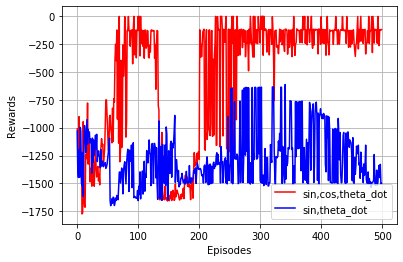

In [17]:
plt.plot(scores,'r',label='sin,cos,theta_dot')
plt.plot(scores2,'b',label='sin,theta_dot')
plt.grid()
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.legend()
plt.show()